In [2]:
!pip install torchsummary


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torch.utils.data import DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# 
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_48/2445223466.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [4]:
!mkdir output

In [6]:
from torchvision.models import efficientnet_b0,densenet121
model=efficientnet_b0(pretrained=True).features
import torch
import torch.nn as nn
dummy_input = torch.randn(1, 3, 224, 224)  # Assuming RGB images of size 224x224

# Forward pass
for i in range(10):    
    output = model[:i](dummy_input)
    print(i,output.shape)
#     print(output.shape)
# print(model)
block1 = nn.Sequential(model)
# print(block1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 187MB/s]


0 torch.Size([1, 3, 224, 224])
1 torch.Size([1, 32, 112, 112])
2 torch.Size([1, 16, 112, 112])
3 torch.Size([1, 24, 56, 56])
4 torch.Size([1, 40, 28, 28])
5 torch.Size([1, 80, 14, 14])
6 torch.Size([1, 112, 14, 14])
7 torch.Size([1, 192, 7, 7])
8 torch.Size([1, 320, 7, 7])
9 torch.Size([1, 1280, 7, 7])


In [7]:
import torch
import torch.nn as nn
from torchvision.models import densenet121,efficientnet_b0


#no change in height and width just no of channels changed
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

#increases height and width by factor of 2 
def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )

# As the template for the DenseNet class was used for this cell and updates were made to it
# we forgot to rename the class to EfficientNetB0. However, internally, the pre-trained model used as the encoder is EfficientNetB0 only
class denseUnet(nn.Module):
    
    def __init__(self,encoder,pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = efficientnet_b0(pretrained=True).features
        for param in self.encoder.parameters():
          param.requires_grad=False

        self.block1 = nn.Sequential(*self.encoder[:1])#h=112 channel=32
        self.block2 = nn.Sequential(*self.encoder[1:2])#h=112 channel=16
        self.block3 = nn.Sequential(*self.encoder[2:3])#h=56 channel=24
        self.block4 = nn.Sequential(*self.encoder[3:4])#h=28 channel=40
        self.block5 = nn.Sequential(*self.encoder[4:5])#h=14 channel=80
        self.block6 = nn.Sequential(*self.encoder[5:6])#h=14 channel=112
        self.block7 = nn.Sequential(*self.encoder[6:7])#h=7 channel=192
        self.block8 = nn.Sequential(*self.encoder[7:8])#h=7 channel=320
        
        self.bottleneck = nn.Sequential(*self.encoder[8:])#h=7 channel 1280
        self.conv_bottleneck = double_conv(1280, 1280)#h=7 channel=1280
        
        self.up_conv8=nn.ConvTranspose2d(1280,320,kernel_size=1,stride=1,padding=0)#h=7 c=320
        self.conv8 = double_conv(640,320)
        self.up_conv7=nn.ConvTranspose2d(320,192,kernel_size=1,stride=1,padding=0)#h=7 c=192
        self.conv7 = double_conv(192+192, 192)
        self.up_conv6=nn.ConvTranspose2d(192,112,kernel_size=2,stride=2,padding=0)#h=14 c=112
        self.conv6 = double_conv(112+112, 112)
        self.up_conv5=nn.ConvTranspose2d(112,80,kernel_size=1,stride=1,padding=0)#h=14 c=80
        self.conv5 = double_conv(80+80,80)
        self.up_conv4=nn.ConvTranspose2d(80,40,kernel_size=2,stride=2,padding=0)#h=28 c=40
        self.conv4 = double_conv(40+40, 40)
        self.up_conv3=nn.ConvTranspose2d(40,24,kernel_size=2,stride=2,padding=0)#h=56 c=24
        self.conv3 = double_conv(24+24, 24)
        self.up_conv2=nn.ConvTranspose2d(24,16,kernel_size=2,stride=2,padding=0)#h=112 c=16
        self.conv2 = double_conv(16+16, 16)
        self.up_conv1=nn.ConvTranspose2d(16,32,kernel_size=1,stride=1,padding=0)#h=112 c=32
        self.conv1 = double_conv(32+32, 32)
        self.up_conv0=nn.ConvTranspose2d(32,1,kernel_size=2,stride=2,padding=0)#h=224 c=1 output
        
    def forward(self, x1):
        #x..h=256 channels=3
        block1 = self.block1(x1)#h=32 channel=128
        block2 = self.block2(block1)#h=16 c=256
        block3 = self.block3(block2)#h=8 c=512
        block4 = self.block4(block3)#h=8 c=512
        block5 = self.block5(block4)#h=8 c=512
        block6 = self.block6(block5)#h=8 c=512
        block7 = self.block7(block6)#h=8 c=512
        block8 = self.block8(block7)#h=8 c=512
        
        bottleneck=self.bottleneck(block8)
        conv_bottleneck=self.conv_bottleneck(bottleneck)
        
        up_conv8=self.up_conv8(conv_bottleneck)#
        if up_conv8.shape != block8.shape:
            up_conv8 = torch.nn.functional.interpolate(up_conv8, size=block8.shape[2:], mode='bilinear', align_corners=False)
        up_conv8 = torch.cat([up_conv8, block8], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv8 = self.conv8(up_conv8)#h=up_conv,c=up_conv8 channel

        up_conv7=self.up_conv7(up_conv8)
        up_conv7 = torch.cat([up_conv7, block7], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv7 = self.conv7(up_conv7)#h=up_conv,c=up_conv8 channel
        #1.up_conv increases resolution ..
        #2.torch.cat makes skip connection between upconv and corresponding block by concat
        #3.conv7 halves the channels as after concatenation no. of channels was doubled

        up_conv6=self.up_conv6(up_conv7)
        up_conv6 = torch.cat([up_conv6, block6], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv6 = self.conv6(up_conv6)#h=up_conv,c=up_conv8 channel

        up_conv5=self.up_conv5(up_conv6)
        up_conv5 = torch.cat([up_conv5, block5], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv5 = self.conv5(up_conv5)#h=up_conv,c=up_conv8 channel

        up_conv4=self.up_conv4(up_conv5)
        up_conv4 = torch.cat([up_conv4, block4], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv4 = self.conv4(up_conv4)#h=up_conv,c=up_conv8 channel

        up_conv3=self.up_conv3(up_conv4)
        up_conv3 = torch.cat([up_conv3, block3], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv3 = self.conv3(up_conv3)#h=up_conv,c=up_conv8 channel

        up_conv2=self.up_conv2(up_conv3)
        up_conv2 = torch.cat([up_conv2, block2], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv2 = self.conv2(up_conv2)#h=up_conv,c=up_conv8 channel

        up_conv1=self.up_conv1(up_conv2)
        up_conv1 = torch.cat([up_conv1, block1], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv1 = self.conv1(up_conv1)#h=up_conv,c=up_conv8 channel

        up_conv0=self.up_conv0(up_conv1)
        
        return up_conv0


def dense_unet(output_dim: int=1, pretrained: bool=False):
    return denseUnet(densenet121, pretrained=pretrained, out_channels=output_dim)

In [9]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.mask = os.listdir(mask_dir)

  def __len__(self):
    return len(self.mask)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.mask[index])

    # img_path = self.image_dir[index]
    # mask_path = self.mask_dir[index]

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    # mask = np.array(Image.open(mask_path))

    mask = (mask//246.0)

    if self.transform != None:
      augmentations = self.transform(image = image,mask = mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image,mask

# def distributeData(train_image,train_mask,train_val):
#     images = os.listdir(train_image)
#     masks = os.listdir(train_mask)

#     for i in range(0,len(images)):
#       images[i] = os.path.join(train_image,images[i])

#     for i in range(0,len(masks)):
#       masks[i] = os.path.join(train_mask,masks[i])


#     train_img, valid_img = images[:int(train_val*len(images))], images[int(train_val*len(images)):]
#     train_mask,valid_mask = masks[:int(train_val*len(masks))],masks[int(train_val*len(masks)):]

#     return train_img,train_mask,valid_img,valid_mask

def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

def check_accuracy(loader,model,accuracy_vals,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))

      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum() + 1e-8)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # index = accu.cpu().data.numpy().argmax()
  print(accu.item())
  accuracy_vals.append(accu.item())

  print(f"Dice score: {dice_score/len(loader)}")
  model.train()

def save_predictions_as_imgs(loader,model,folder,device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [10]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  # train_img,train_mask,val_img,val_mask = distributeData(train_dir,train_maskdir,train_val)

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [11]:
# Dataset (BTP 1 and 2)
# Hyperparameters
# LEARNING_RATE = [1e-4,1e-3,1e-2]
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
train_valid = 0.8
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/input/slumdata/updated_complete_data/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slumdata/updated_complete_data/train_mask'
val_dir = '/kaggle/input/slumdata/updated_complete_data/val_img'
val_mask_dir = '/kaggle/input/slumdata/updated_complete_data/val_mask'
saved_folder = '/kaggle/working/output'

#small data

# TRAIN_IMG_DIR = '/kaggle/input/small-slum-data/small_data/train_img'
# TRAIN_MASK_DIR = '/kaggle/input/small-slum-data/small_data/train_mask'
# val_dir = '/kaggle/input/small-slum-data/small_data/val_img'
# val_mask_dir = '/kaggle/input/small-slum-data/small_data/val_mask'
# saved_folder = '/kaggle/working/output'

In [12]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0
  accuracy_s = []

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
    
      for pred_mask,gt_mask in zip(preds,yy):
        x = np.mean(gt_mask.flatten() == pred_mask.flatten())
        accuracy_s.append(x)

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      # total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  # average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(np.mean(accuracy_s))

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {np.mean(accuracy_s):4f}"
  )


In [14]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()

      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 178/178 [05:29<00:00,  1.85s/it, loss=0.19] 


Epoch [1/10], Loss: 0.2337, IoU: 0.4055, Precision: 0.4749, Recall: 0.7379, F1: 0.5710,Accuracy: 0.677124
=> Saving checkpoint
Got 26246238/35624960 with accuracy 73.67373657226562
Average Precision: 0.3803
Accuracy: 0.7367373324770049
Average Dice Score: 0.5132
Average F1 Score: 0.5132
Average IoU Score: 0.3708


100%|██████████| 178/178 [05:30<00:00,  1.86s/it, loss=0.165]


Epoch [2/10], Loss: 0.1984, IoU: 0.5422, Precision: 0.6477, Recall: 0.7787, F1: 0.7012,Accuracy: 0.814774
=> Saving checkpoint
Got 27063211/35624960 with accuracy 75.96699523925781
Average Precision: 0.4009
Accuracy: 0.7596699336644869
Average Dice Score: 0.5324
Average F1 Score: 0.5324
Average IoU Score: 0.3890


100%|██████████| 178/178 [05:19<00:00,  1.80s/it, loss=0.182]


Epoch [3/10], Loss: 0.1854, IoU: 0.5734, Precision: 0.6998, Recall: 0.7688, F1: 0.7271,Accuracy: 0.839258
=> Saving checkpoint
Got 31204628/35624960 with accuracy 87.59203338623047
Average Precision: 0.5913
Accuracy: 0.875920365945674
Average Dice Score: 0.6421
Average F1 Score: 0.6421
Average IoU Score: 0.4957


100%|██████████| 178/178 [05:34<00:00,  1.88s/it, loss=0.182]


Epoch [4/10], Loss: 0.1800, IoU: 0.5814, Precision: 0.7115, Recall: 0.7700, F1: 0.7339,Accuracy: 0.844489
=> Saving checkpoint
Got 30607082/35624960 with accuracy 85.91471099853516
Average Precision: 0.5392
Accuracy: 0.8591471260599312
Average Dice Score: 0.6289
Average F1 Score: 0.6289
Average IoU Score: 0.4831


100%|██████████| 178/178 [05:27<00:00,  1.84s/it, loss=0.211]


Epoch [5/10], Loss: 0.1790, IoU: 0.5860, Precision: 0.7167, Recall: 0.7697, F1: 0.7374,Accuracy: 0.847104
=> Saving checkpoint
Got 30792444/35624960 with accuracy 86.43502807617188
Average Precision: 0.5537
Accuracy: 0.8643502757617132
Average Dice Score: 0.6344
Average F1 Score: 0.6344
Average IoU Score: 0.4888


100%|██████████| 178/178 [05:30<00:00,  1.85s/it, loss=0.183]


Epoch [6/10], Loss: 0.1783, IoU: 0.5852, Precision: 0.7172, Recall: 0.7697, F1: 0.7365,Accuracy: 0.847157
=> Saving checkpoint
Got 30920145/35624960 with accuracy 86.79348754882812
Average Precision: 0.5562
Accuracy: 0.867934869260204
Average Dice Score: 0.6481
Average F1 Score: 0.6481
Average IoU Score: 0.5033


100%|██████████| 178/178 [05:33<00:00,  1.87s/it, loss=0.199]


Epoch [7/10], Loss: 0.1774, IoU: 0.5869, Precision: 0.7189, Recall: 0.7715, F1: 0.7382,Accuracy: 0.847776
=> Saving checkpoint
Got 30890104/35624960 with accuracy 86.70916748046875
Average Precision: 0.5558
Accuracy: 0.8670916121730382
Average Dice Score: 0.6451
Average F1 Score: 0.6451
Average IoU Score: 0.5000


100%|██████████| 178/178 [05:27<00:00,  1.84s/it, loss=0.151]


Epoch [8/10], Loss: 0.1763, IoU: 0.5940, Precision: 0.7252, Recall: 0.7746, F1: 0.7438,Accuracy: 0.850900
=> Saving checkpoint
Got 30312136/35624960 with accuracy 85.0867919921875
Average Precision: 0.5195
Accuracy: 0.8508679307990803
Average Dice Score: 0.6250
Average F1 Score: 0.6250
Average IoU Score: 0.4798


100%|██████████| 178/178 [05:26<00:00,  1.83s/it, loss=0.175]


Epoch [9/10], Loss: 0.1765, IoU: 0.5917, Precision: 0.7233, Recall: 0.7725, F1: 0.7419,Accuracy: 0.849970
=> Saving checkpoint
Got 30573483/35624960 with accuracy 85.82040405273438
Average Precision: 0.5390
Accuracy: 0.8582039951764155
Average Dice Score: 0.6281
Average F1 Score: 0.6281
Average IoU Score: 0.4827


100%|██████████| 178/178 [05:28<00:00,  1.84s/it, loss=0.18] 


Epoch [10/10], Loss: 0.1765, IoU: 0.5913, Precision: 0.7229, Recall: 0.7739, F1: 0.7418,Accuracy: 0.849769
=> Saving checkpoint
Got 30303269/35624960 with accuracy 85.06190490722656
Average Precision: 0.5201
Accuracy: 0.8506190322740012
Average Dice Score: 0.6251
Average F1 Score: 0.6251
Average IoU Score: 0.4796
Training finished
loss_train : [0.23373611229524183, 0.19837126746941147, 0.18539048957355905, 0.1800435542892874, 0.17902025697606333, 0.17832661830307392, 0.17740042189533792, 0.1763154717811038, 0.17650169582011993, 0.1765310178312023]
iou_train : [0.40551523154435276, 0.5422203805610293, 0.5734428404620733, 0.5814332804584041, 0.585962867034661, 0.5851662792731414, 0.5869168178910436, 0.5939883527478638, 0.5916530849190749, 0.5913485370950131]
precision_train : [0.4749470889892576, 0.6476698329589992, 0.6997691072419433, 0.7114520832263226, 0.7167173006984909, 0.7172417640995075, 0.7188643642425027, 0.7251977865396111, 0.7233243287970499, 0.7229198708629051]
recall_train :

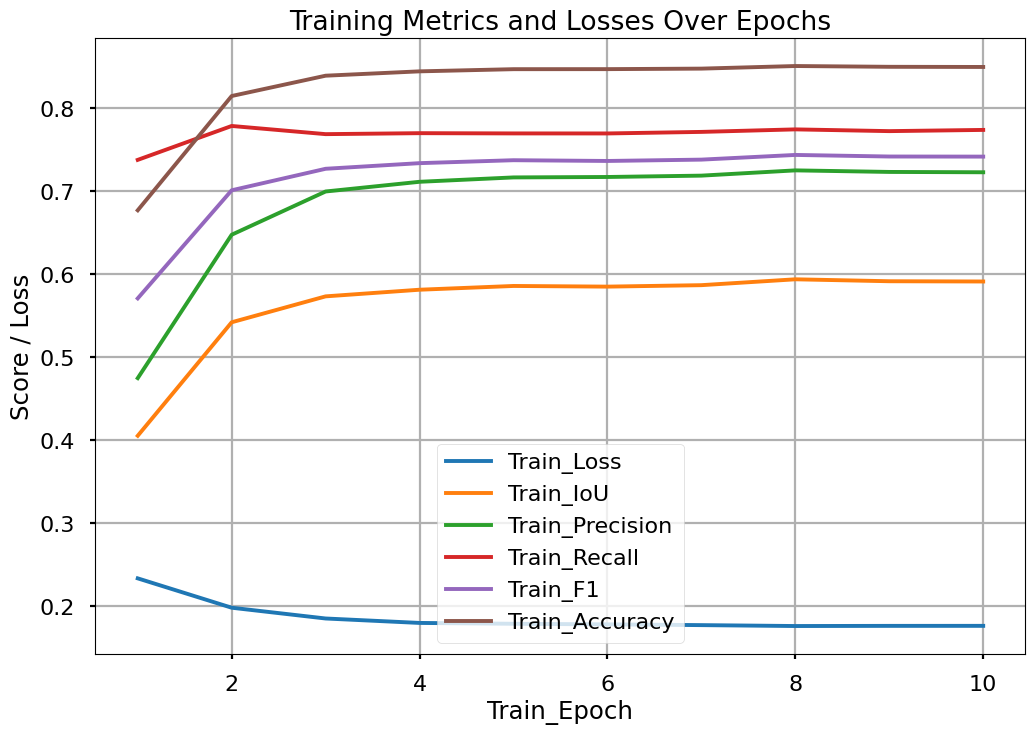

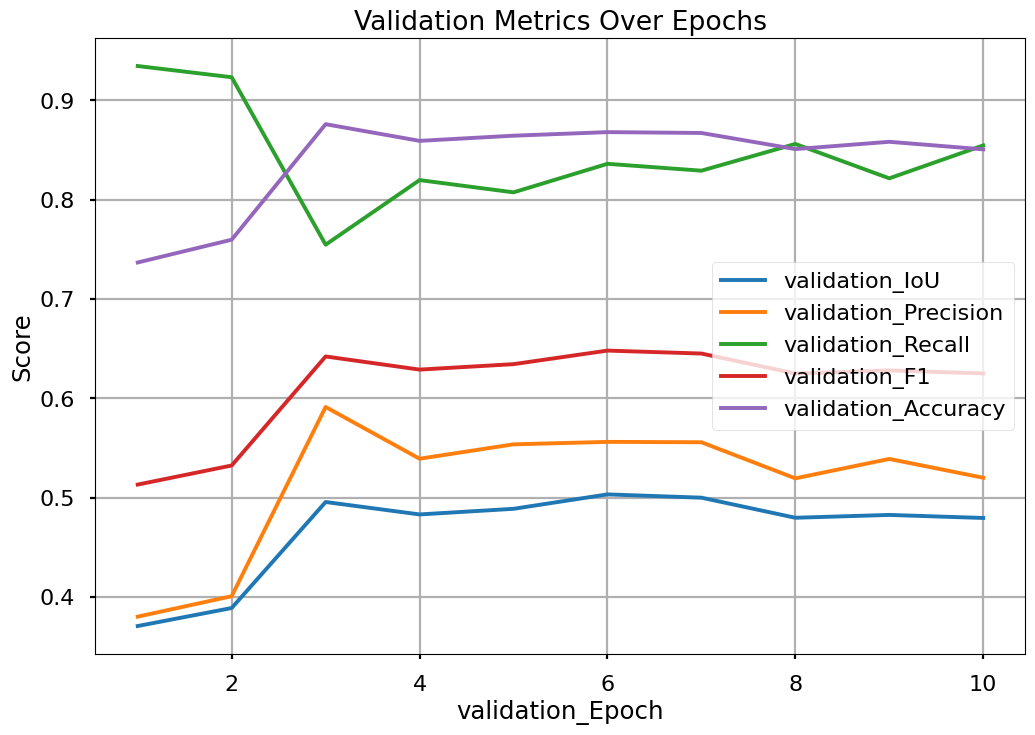

In [15]:
from torch.optim.lr_scheduler import StepLR
def main():
  # data augumentation:
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.1),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 255.0
      ),
      ToTensorV2(),
    ],is_check_shapes = False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 255.0
    ),
    ToTensorV2(),
  ],is_check_shapes = False
  )

  # model instance:
  model = dense_unet().to(DEVICE)

  # defining loss:
  loss_fn = FocalLoss()

  #defining optimizer:
  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # setting loaders:
  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  # if LOAD_MODEL :
  #   load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  # check_accuracy(val_loader,model,device = DEVICE)

  scaler = torch.cuda.amp.GradScaler()


# Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

 # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

 # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = DEVICE)
            
    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder = saved_folder,device = DEVICE
    )
  print("Training finished")

  # Plot metrics and losses
  # Plot for Training dataset
  print(f'loss_train : {loss_train}')
  print(f'iou_train : {iou_train}')
  print(f'precision_train : {precision_train}')
  print(f'recall_train : {recall_train}')
  print(f'f1_train : {f1_train}')
  print(f'Accuracy_train : {accuracy_train}')

  
  print(f'Validation result')
  print(f'f1_val: {f1_val}')
  print(f'dice_scores : {dice_scores}')
  print(f'iou_scores : {iou_scores}')
  print(f'precision_scores : {precision_scores}')
  print(f'recall_scores : {recall_scores}')
  print(f'Accuracy_scores : {accuracy_vals}')

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, dice_scores, label='validation_F1')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

#   summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

#   func(NUM_EPOCHS,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals)

if __name__ == "__main__":
  main()